<a href="https://colab.research.google.com/github/dionq99/Hacktiv8_FinalProject/blob/main/PYIM_Assgn_Final_8_Dion_Qairawan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FAKE NEWS**

Fake news are misinformation intended to cause disadvantages towards a specific party or person, usually in the opposition of the one spreading the news. In the ages of internet and social media, these news can spread even faster than wildfires. Combined with low level of literacy from social media users, this could possibly lead to group violence, public disorder, death threats, or even suicides.

It is important to have a system that can quickly determine if a certain article contain hoaxes or not, especially when people nowadays often read partially (or even only the headlines) and jumps to conclusion. Thus, in this session i will attempt to develop a model that can detect if a news article is fake or not

**FAKE AND REAL NEWS DATASET**

This dataset consists of about 40000 articles consisting of fake as well as real news. Our aim is train our model so that it can correctly predict whether a given piece of news is real or fake.The fake and real news data is given in two separate datasets with each dataset consisting around 20000 articles each.

The dataset can be downloaded from:
 https://drive.google.com/drive/folders/19QP6HpLLvw2N8WBzI6LPjONi9k_tr0zw?usp=sharing

**LOADING ALL REQUIRED LIBRARIES**

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from collections import Counter
import tensorflow as tf

**IMPORTING THE DATASET**

In [ ]:
true = files.upload()

Saving True.csv to True.csv


In [ ]:
fake = files.upload()

Saving Fake.csv to Fake.csv


In [ ]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Add a category field to differentiate true & fake news then merge the 2 datasets

In [ ]:
true['category'] = 1
false['category'] = 0
df = pd.concat([true,false])

**DATA VISUALIZATION & PREPROCESSING**

Firstly check the distribution of category

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


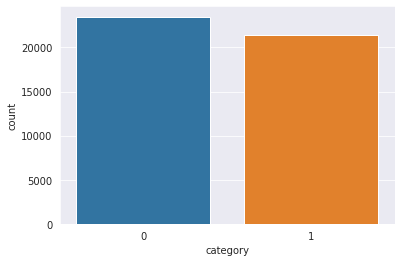

In [ ]:
sns.set_style("darkgrid")
sns.countplot(df.category)

It seems that the dataset is balanced as both category have similar amount of data

Next, check if there are NaN values

In [ ]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [ ]:
df.title.count()

44898

Check the distribution of subjects

In [ ]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

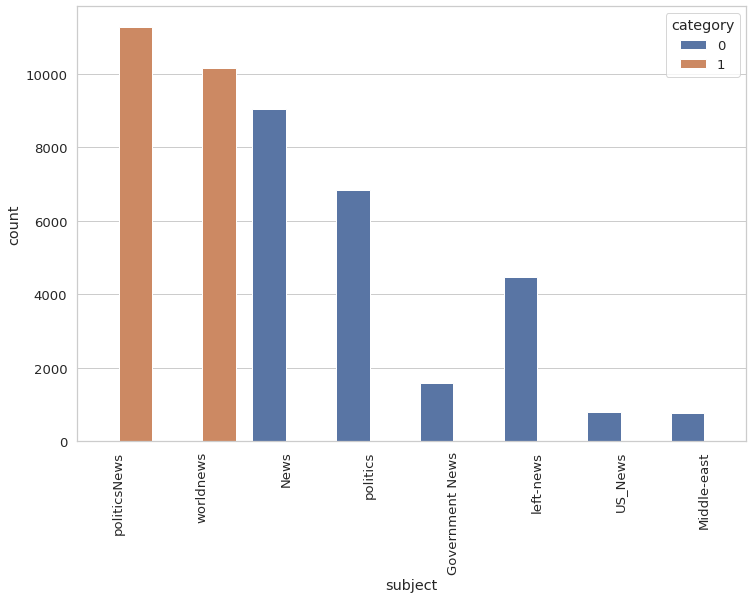

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

Since the subjects for both category are completely different, we have to exclude it from the analysis to avoid bias

In [ ]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

Prepare Stopwords. Stopwords are words that don't really add meaning to the sentence. They can safely be ignored without hurting the sentence.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

Clean the data

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_url(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on text column
df['text']=df['text'].apply(denoise_text)

Check words dominancy from both category on cleaned data

In [ ]:
df['text']

0        WASHINGTON (Reuters) head conservative Republi...
1        WASHINGTON (Reuters) Transgender people allowe...
2        WASHINGTON (Reuters) special counsel investiga...
3        WASHINGTON (Reuters) Trump campaign adviser Ge...
4        SEATTLE/WASHINGTON (Reuters) President Donald ...
                               ...                        
23476    21st Century Wire says 21WIRE reported earlier...
23477    21st Century Wire says familiar theme. Wheneve...
23478    Patrick Henningsen 21st Century WireRemember O...
23479    21st Century Wire says Al Jazeera America go h...
23480    21st Century Wire says 21WIRE predicted new ye...
Name: text, Length: 44898, dtype: object

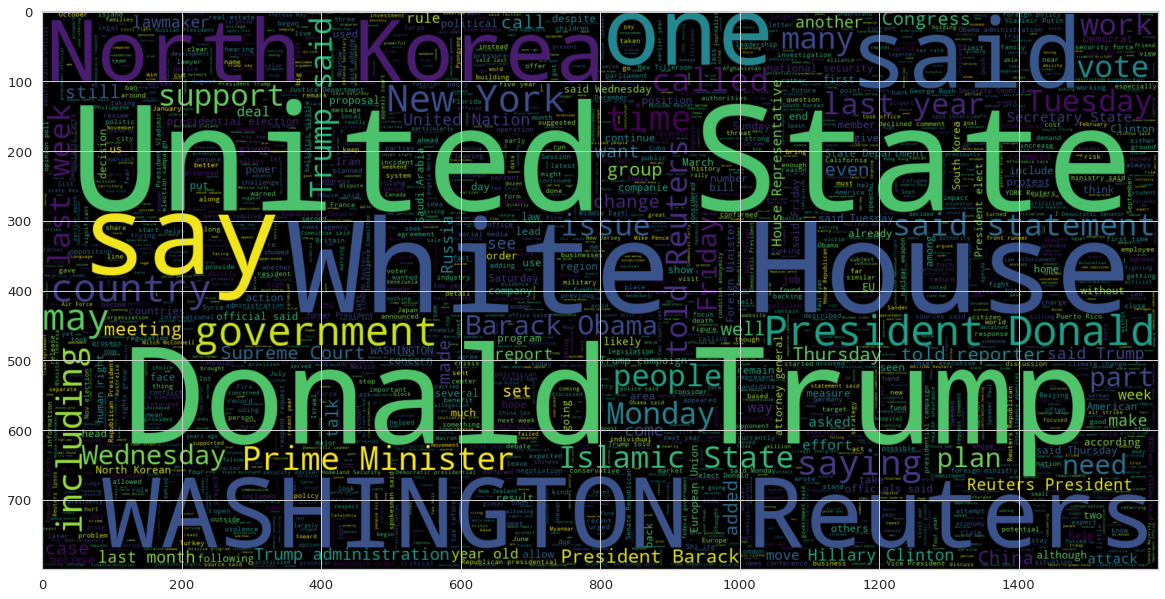

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

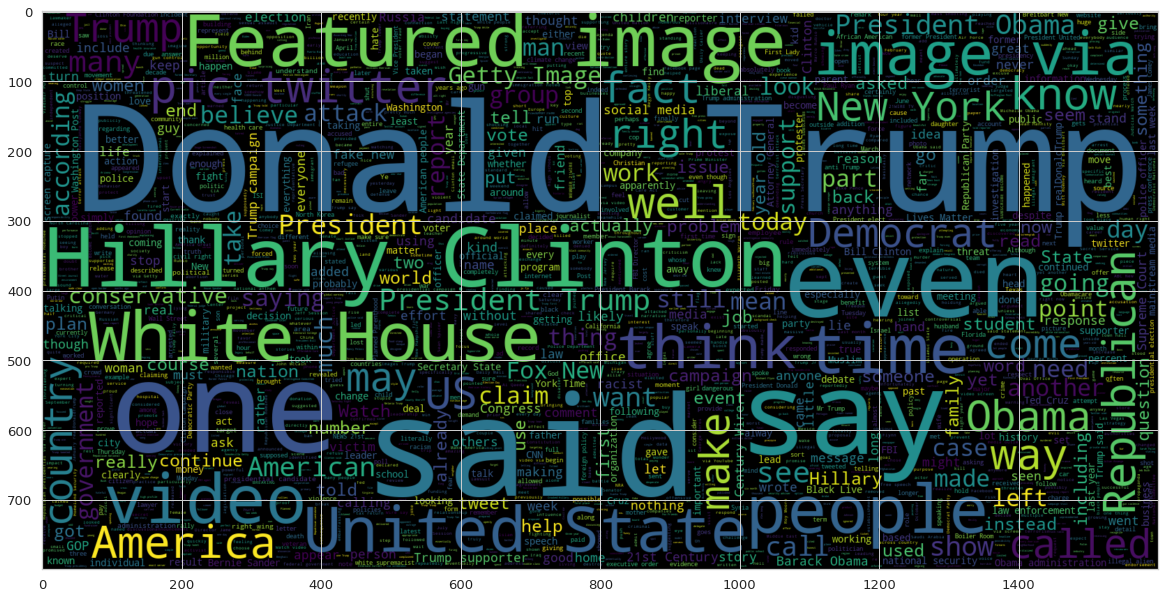

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

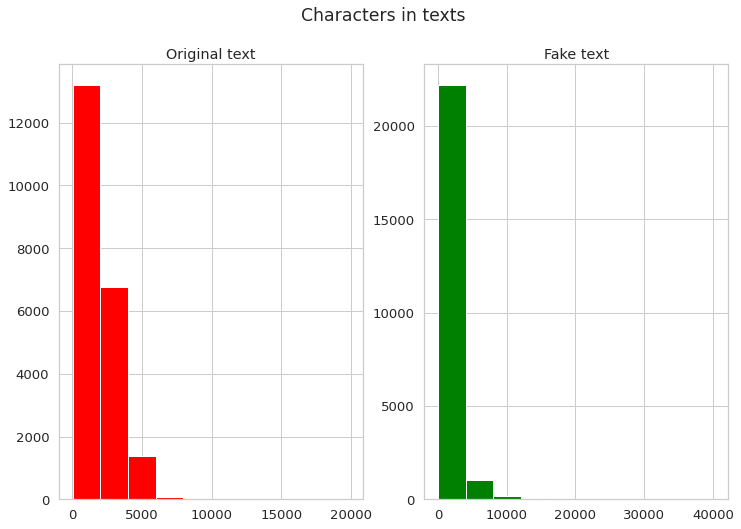

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

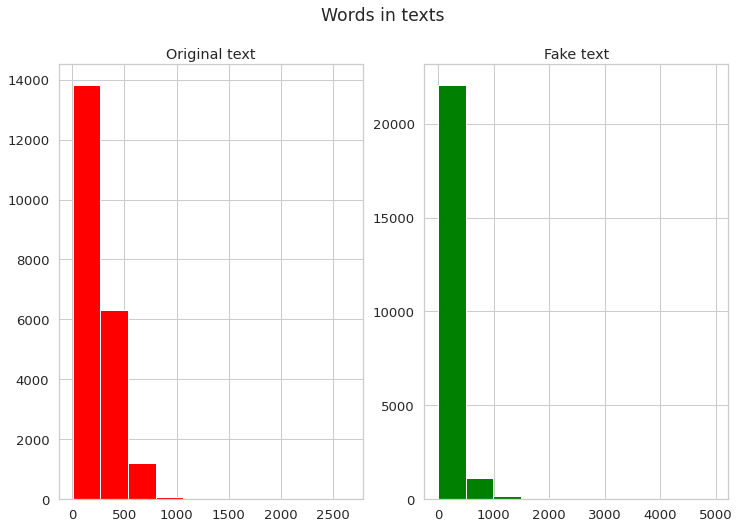

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

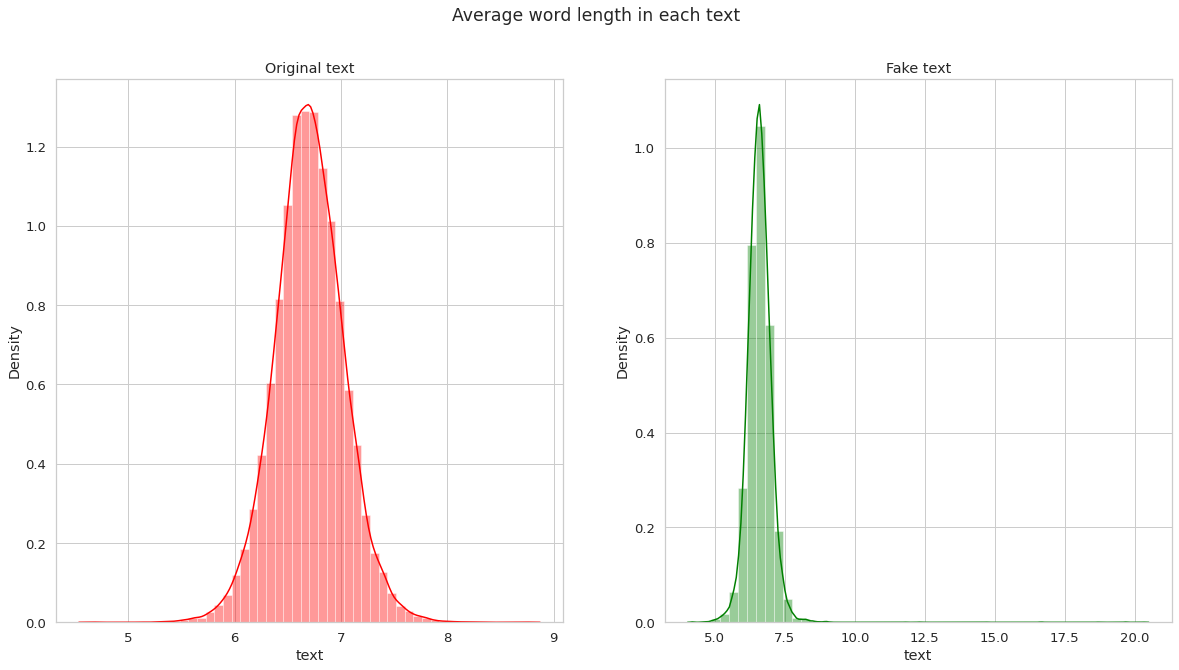

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

Check the most common words and phrases in texts

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [ ]:
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Donald': 27795,
 'President': 33180,
 'Trump': 111503,
 'U.S.': 50441,
 'also': 30325,
 'one': 29370,
 'people': 33115,
 'said': 93162,
 'said.': 26194,
 'would': 54613}

In [ ]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

1 word

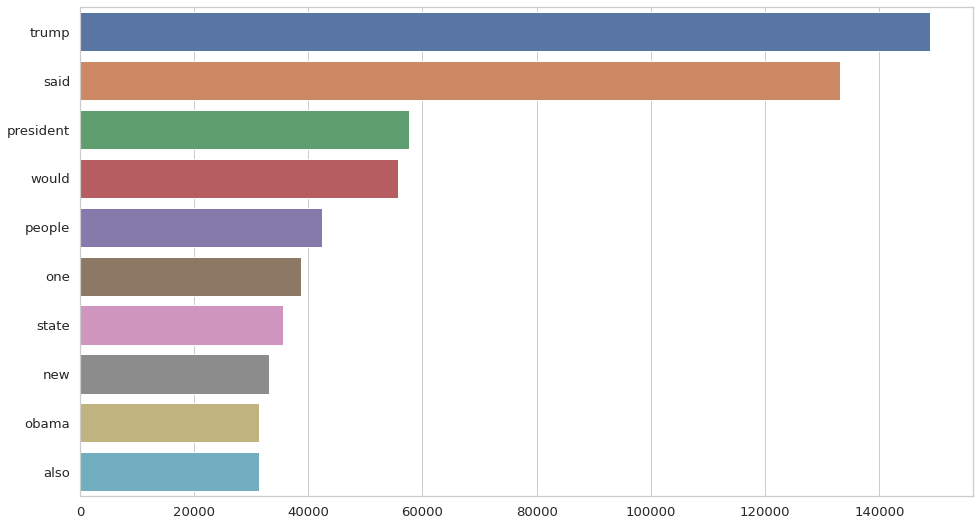

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

2 word phrase

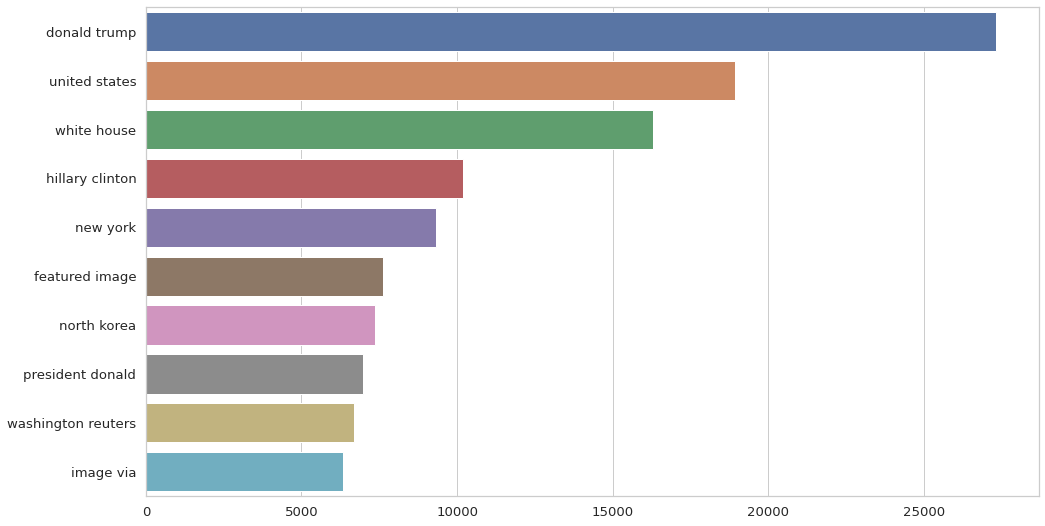

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

3 word phrase

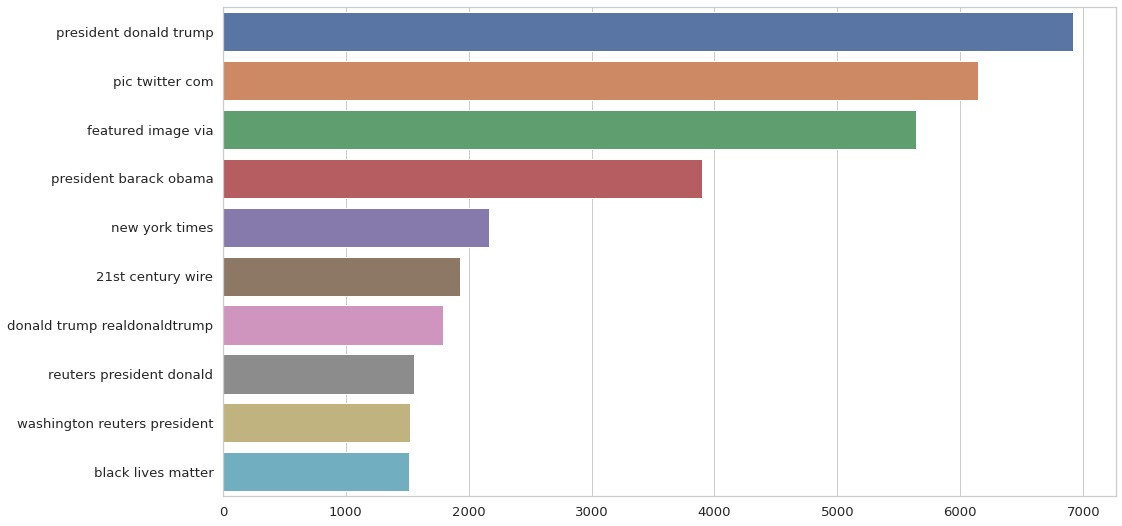

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

**SPLIT DATASET INTO TRAINING AND TESTING DATASET**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [ ]:
max_features = 10000
maxlen = 300

**TOKENIZE TEXTS**

Representing each word with a number. I'll keep news to 300 words, add padding to news shorter than 300 words and truncate long ones.

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip

--2021-07-24 03:21:58--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.06MB/s    in 4m 45s  

2021-07-24 03:26:43 (5.08 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [ ]:
!unzip -q glove.twitter.27B.zip

In [ ]:
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


**MODEL PREPARATION**

Some basic model parameters

In [ ]:
batch_size = 256
epochs = 15
embed_size = 100

Callbacks

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

log_dir="logs/fit/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=1000000)

filename = 'model_test.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=1, save_best_only=True)

Defining model

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embedding layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


**MODEL TRAINING**

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction, tensorboard_callback, checkpoint])

Epoch 1/15
132/132 [==============================] - 335s 2s/step - loss: 0.2772 - accuracy: 0.8630 - val_loss: 0.0564 - val_accuracy: 0.9780
Epoch 2/15
132/132 [==============================] - 299s 2s/step - loss: 0.0444 - accuracy: 0.9851 - val_loss: 0.0195 - val_accuracy: 0.9942
Epoch 3/15
132/132 [==============================] - 299s 2s/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0124 - val_accuracy: 0.9968
Epoch 4/15
132/132 [==============================] - 297s 2s/step - loss: 0.0113 - accuracy: 0.9968 - val_loss: 0.0084 - val_accuracy: 0.9969
Epoch 5/15
132/132 [==============================] - 297s 2s/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 0.0097 - val_accuracy: 0.9964

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 6/15
132/132 [==============================] - 297s 2s/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0048 - val_accuracy: 0.9983
Epoch 7/15
132/132 [==============================] - 296s 2s/

**AFTER TRAINING ANALYSIS**

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 147s 139ms/step - loss: 1.1560e-04 - accuracy: 1.0000
Accuracy of the model on Training Data is -  99.99703168869019 %
351/351 [==============================] - 50s 143ms/step - loss: 0.0045 - accuracy: 0.9992
Accuracy of the model on Testing Data is -  99.91981983184814 %


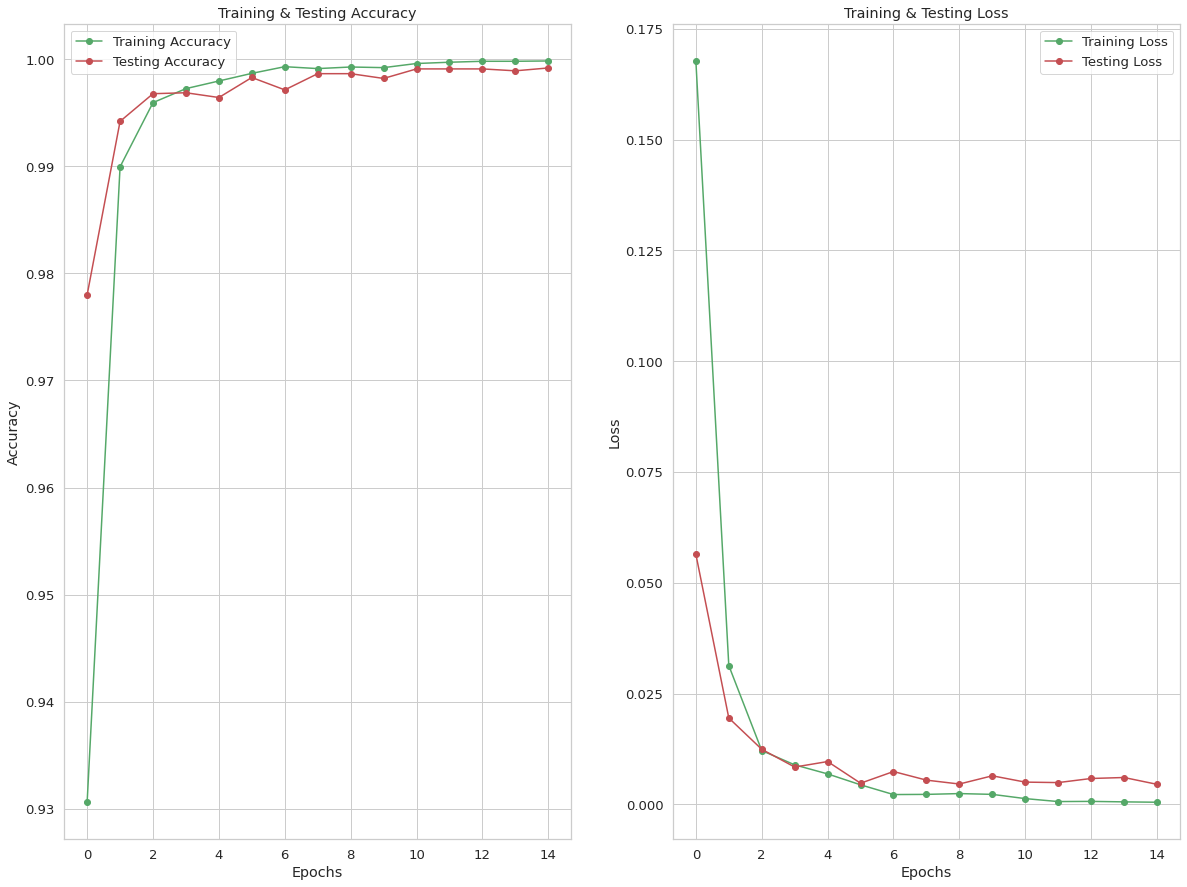

In [ ]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,15)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

**EVALUATE THE MODEL AGAINST TESTING DATASET**

I will compare results from predicting texts against the its true category value on testing dataset. Confusion matrix will be used to visualize the comparison

In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])
cm

array([[5854,    4],
       [   5, 5362]])

Text(63.5, 0.5, 'Actual')

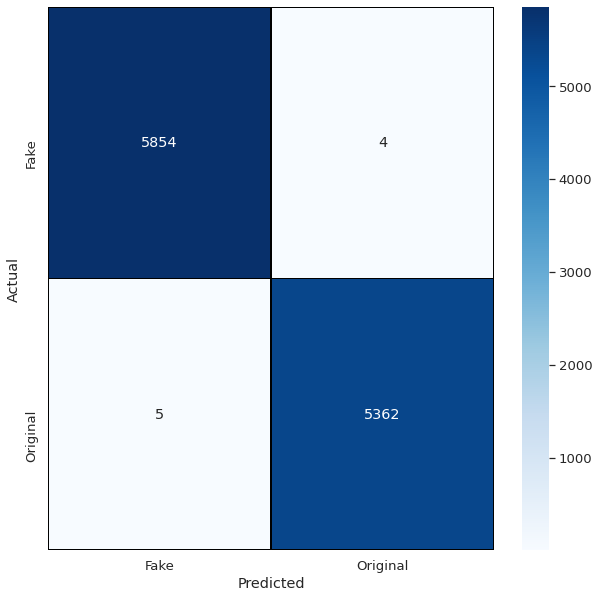

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

**SAVE THE MODEL**

In [ ]:
model.save('model.h5')

**TRY THE MODEL TO PREDICT AN ARTICLE OUTSIDE OF THE DATASET**

In [ ]:
sample_text = ('Over three million first doses of Covid vaccines have been administered in Scotland, and only a very small number of people are thought to have died. However, our thoughts and sympathies are always with those few affected, and their families. The spokesperson added that vaccines remained the "best way" to protect people from Covid-19 and had already saved thousands of lives.')
sample_text

'Over three million first doses of Covid vaccines have been administered in Scotland, and only a very small number of people are thought to have died. However, our thoughts and sympathies are always with those few affected, and their families. The spokesperson added that vaccines remained the "best way" to protect people from Covid-19 and had already saved thousands of lives.'

Preprocess the article

In [ ]:
sample_text = denoise_text(sample_text)
tokenized_text = tokenizer.texts_to_sequences(sample_text)
sample_text = sequence.pad_sequences(tokenized_text, maxlen=maxlen)

Predict whether it is real or fake

In [ ]:
predictions = model.predict(sample_text)
index = int(predictions[0])

label_class=[]
label_class.append("Fake") #0
label_class.append("True") #1

print("This article is:")
print(label_class[index])

This article is:
Fake


In [ ]:
sample_text2 = 'WASHINGTON (Reuters) - President Donald Trump on Thursday announced a $500 million investment that Corning Inc is making with pharmaceutical giants Merck and Pfizer to manufacture a new kind of glass for injectable drug vials. At a White House event, Trump said the effort will create nearly 1,000 jobs at facilities in New York and New Jersey and at a soon-to-be-determined site in the southeastern United States. The deal could eventually result in a total investment of $4 billion and create around 4,000 jobs, Trump said, joined by the CEOs of Corning, Merck and Pfizer. The commitments were made as part of Trumps Made in America week, during which he has showcased American-made products and made an impassioned defense of his America First policies. Corning said it developed the new type of glass in collaboration with the drugmakers. This initiative will bring a key industry to our shores that for too long has been dominated by foreign countries. We are moving more and more companies back into the United States, Trump said. After the remarks, Trump tested the strength of the new Corning Valor Vial. Pressing down on an old vial in a vise-like machine, he easily broke it but struggled to break one of the new vials despite putting far greater effort into it. '
sample_text2

'WASHINGTON (Reuters) President Donald Trump Thursday announced $500 million investment Corning Inc making pharmaceutical giants Merck Pfizer manufacture new kind glass injectable drug vials. White House event, Trump said effort create nearly 1,000 jobs facilities New York New Jersey soon-to-be-determined site southeastern United States. deal could eventually result total investment $4 billion create around 4,000 jobs, Trump said, joined CEOs Corning, Merck Pfizer. commitments made part Trumps Made America week, showcased American-made products made impassioned defense America First policies. Corning said developed new type glass collaboration drugmakers. initiative bring key industry shores long dominated foreign countries. moving companies back United States, Trump said. remarks, Trump tested strength new Corning Valor Vial. Pressing old vial vise-like machine, easily broke struggled break one new vials despite putting far greater effort it.'

In [ ]:
sample_text2 = denoise_text(sample_text2)
tokenized_text2 = tokenizer.texts_to_sequences(sample_text2)
sample_text2 = sequence.pad_sequences(tokenized_text2, maxlen=maxlen)

In [ ]:
predictions = model.predict(sample_text2)
index = int(predictions[0])

label_class=[]
label_class.append("Fake") #0
label_class.append("True") #1

print("This article is:")
print(label_class[index])

This article is:
Fake


**CONCLUSION**

The two tests show that it is still not accurate to determine whether a news article is fake or real. Although it is probably due to the newer topics of the article, since the dataset used to train the model still has not included articles related to COVID-19 and the vaccines. It seems like this model has to be periodically retrained with more varying datasets to be more accurate on recent topics